In [1]:
from os import listdir
from importlib import reload
import numpy as np
import pyxdf
import mne
from utils import split_streams

In [2]:
#reload(utils)

path = 'C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm/'
plot = False

# List files in folder:
files = [f for f in listdir(path)]

# Load all recorded EEG files for one subject
for count in range(len(files)):

    fname = path + '/' + files[count]
    streams, header = pyxdf.load_xdf(fname)


    # Split the streams:
    eeg_stream, marker_stream = split_streams(streams)

    eeg = eeg_stream['time_series'].T
    eeg *= 1e-6 # Convert to volts.
    assert eeg.shape[0] == 65
    eeg_ts = eeg_stream['time_stamps']

    markers = marker_stream['time_series']
    # Convert list of list of strings to list of strings:
    markers = [''.join(element) for element in markers]

    # Convert marker strings to integers:
    classes = ['LTR-s', 'LTR-l','RTL-s', 'RTL-l', 'TTB-s', 'TTB-l', 'BTT-s', 'BTT-l']
    classes_map = [1,1,1,1,2,2,2,2]# [1, 2, 1, 2, 1, 2, 1, 2]  #[1, 2, 3, 4, 5, 6, 7, 8]
    timings = ['Start', 'Cue', 'Break']
    timings_map = [11, 12, 13]
    responses = ['c c 0', 'c c 1', 'c r 0', 'c r 1', 'c l 0', 'c l 1', 'c b 0', 'c b 1', 'c t 0', 'c t 1']
    responses_map = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

    concat_codes = classes + timings + responses
    concat_mappings = classes_map + timings_map + responses_map

    coded_markers = markers.copy()

    for i,marker in enumerate(markers):
        for j,code in enumerate(concat_codes):
            if code in marker:
                coded_markers[i] = concat_mappings[j]

    markers_ts = marker_stream['time_stamps']

    # Make Nan array with len(eeg)
    aligned_markers = np.zeros(eeg_ts.shape)

    # Place markers string at the align array where first time markers_ts <= eeg_ts:
    for i,marker in enumerate(coded_markers):
        ts = markers_ts[i]
        idx = np.where(ts <= eeg_ts)[0][0]
        aligned_markers[idx] = marker


    # Replace last row (unused Brainproduct markers) with the aligned recorded markers:
    eeg[64,:] = aligned_markers

    fs = float(eeg_stream['info']['nominal_srate'][0])

    # Extract channel names:
    chn_names = [eeg_stream['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(64)]
    chn_names.append('Markers')
    chn_labels = ['eeg' for i in range(64)]
    chn_labels[16] = 'eog'
    chn_labels[21] = 'eog'
    chn_labels[40] = 'eog'
    chn_labels.append('misc')

    if count == 0:
        global_eeg = eeg
    else:        
        global_eeg = np.concatenate((global_eeg, eeg), axis=1)
    
    print(global_eeg.shape)

eeg = global_eeg

(65, 88008)
(65, 175212)
(65, 262616)
(65, 349624)
(65, 436928)
(65, 524228)
(65, 613436)
(65, 700240)
(65, 787344)


In [3]:
info = mne.create_info(chn_names, fs, chn_labels)

In [4]:
raw = mne.io.RawArray(eeg, info)
raw.set_montage('standard_1005')
if plot:
    raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
         remove_dc=False, title='Raw')

Creating RawArray with float64 data, n_channels=65, n_times=787344
    Range : 0 ... 787343 =      0.000 ...  3936.715 secs
Ready.


In [7]:
raw.info['bads'].append('T8')
#raw.info['bads'].extend(['EEG 051', 'EEG 052'])  # add a list of channels

In [11]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 61 EEG, 3 EOG, 1 misc
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 200.0 Hz
>

In [12]:
eeg_ts.shape

(87300,)

### Filtering
Highpass at 0.4 Hz<br>
Bandstop at 50 Hz

In [9]:
#raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
#         remove_dc=False, title='Raw')

393608


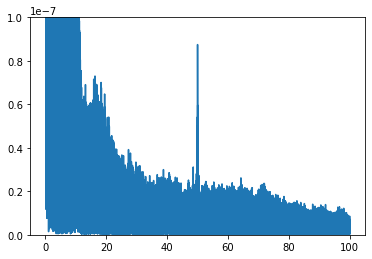

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

N = raw.n_times
print(N//2)
T = 1.0 / raw.info['sfreq']
y, times = raw[0, :]  
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
y_plot = 2.0/N * np.abs(yf[:,:N//2])
plt.plot(xf, y_plot[0,:])
plt.ylim([0,0.0000001])
plt.show()

In [15]:
# raw_highpass = mne.filter.filter_data(raw.get_data(), raw.info['sfreq'], l_freq=0.4, h_freq=None, method='iir')
raw_highpass = raw.copy().filter(l_freq=0.4, h_freq=None, picks=['eeg'], method='iir')
if plot:
    raw_highpass.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
         remove_dc=False, title='Highpass filtered')



Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.40 Hz: -6.02 dB



393608


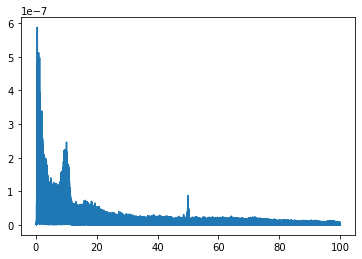

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

N = raw_highpass.n_times
print(N//2)
T = 1.0 / raw_highpass.info['sfreq']
y, times = raw_highpass[0, :]  
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
y_plot = 2.0/N * np.abs(yf[:,:N//2])
plt.plot(xf, y_plot[0,:])
#plt.ylim([0,0.0000001])
plt.show()

Bandstop 50Hz

In [17]:
raw_notch = raw_highpass.copy().notch_filter(freqs=[50], picks=['eeg'])
if plot:
    raw_notch.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False, title='Notch filtered')



Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



393608


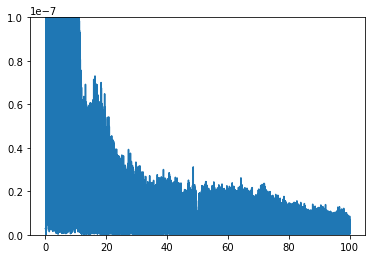

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

N = raw_notch.n_times
print(N//2)
T = 1.0 / raw_notch.info['sfreq']
y, times = raw_notch[0, :]  
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
y_plot = 2.0/N * np.abs(yf[:,:N//2])
plt.plot(xf, y_plot[0,:])
plt.ylim([0,0.0000001])
plt.show()

### Bad channel interpolation

### ICA

In [11]:
ica = mne.preprocessing.ICA(n_components=15, max_iter='auto', random_state=97)

In [106]:
ica.fit(raw_notch)

<ICA | raw data decomposition, method: fastica (fit in 40 iterations on 797516 samples), 15 ICA components explaining 94.6 % of variance (61 PCA components available), channel types: eeg, no sources marked for exclusion>

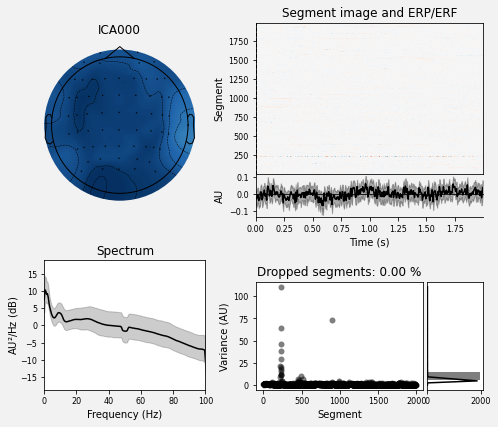

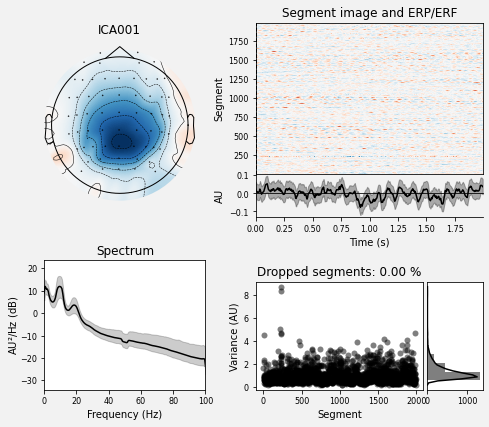

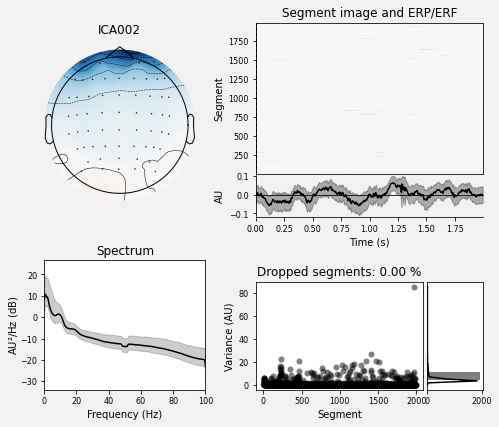

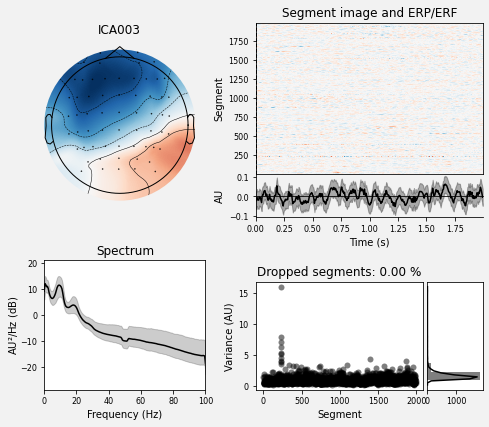

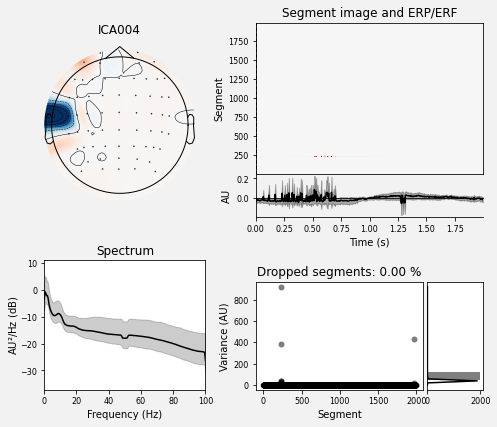

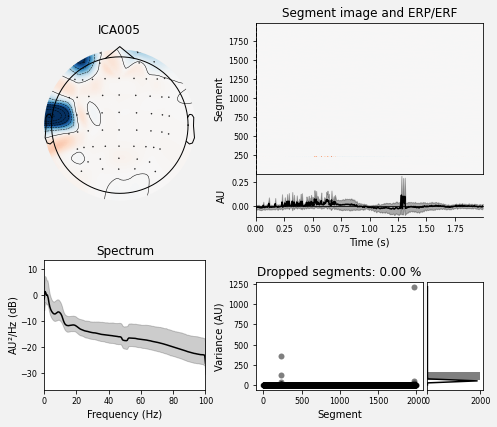

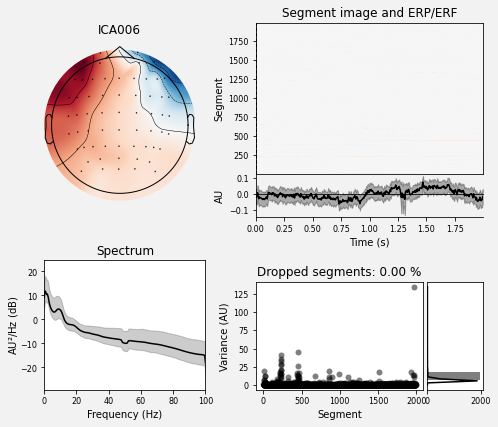

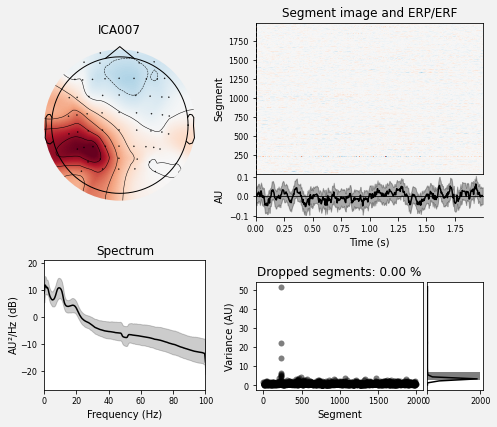

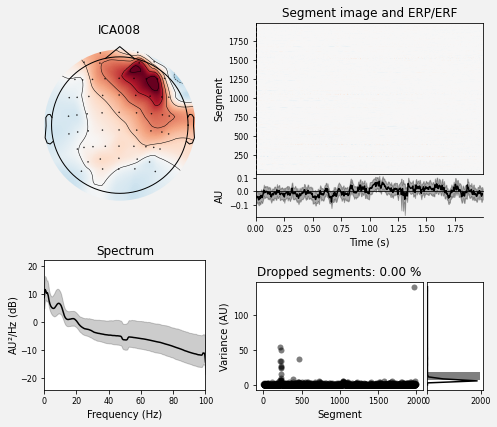

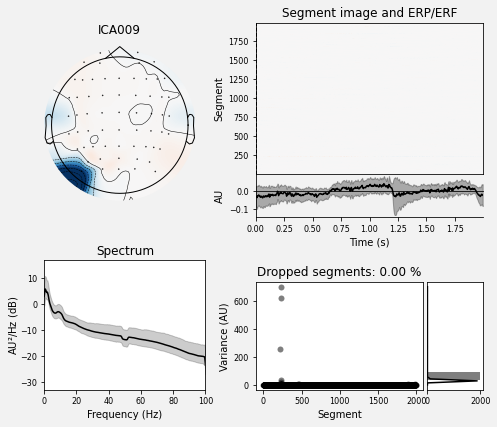

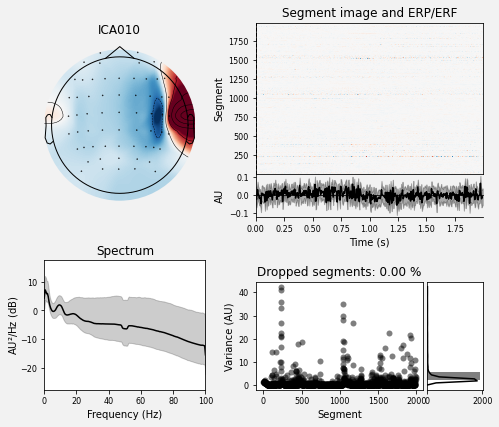

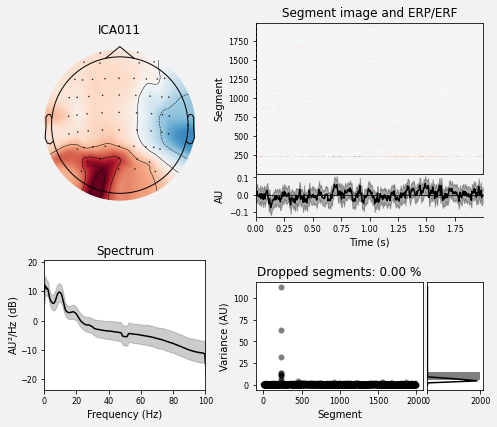

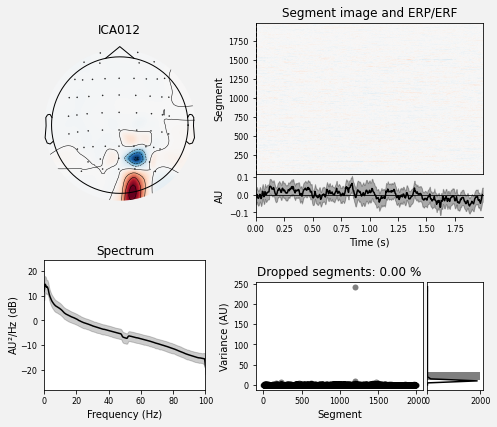

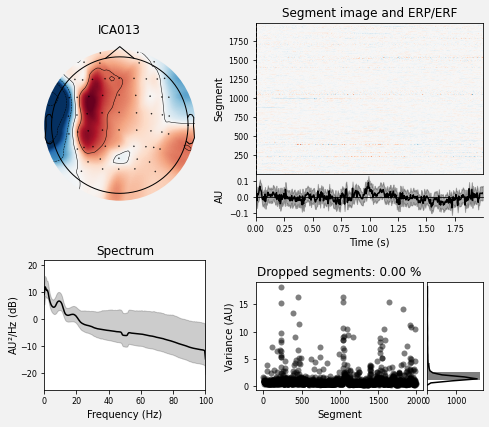

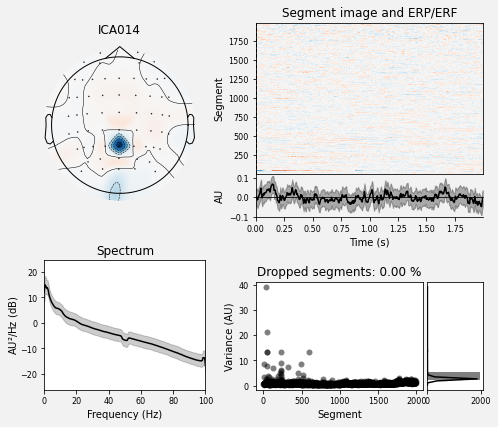

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [108]:
ica.plot_properties(raw_notch, picks=[0,1, 2, 3,4,5,6,7,8,9,10,11,12,13,14])

### Eye artifact correction

In [100]:
mne.channels.get_builtin_montages()

['EGI_256',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'biosemi128',
 'biosemi16',
 'biosemi160',
 'biosemi256',
 'biosemi32',
 'biosemi64',
 'easycap-M1',
 'easycap-M10',
 'mgh60',
 'mgh70',
 'standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'artinis-octamon',
 'artinis-brite23']

### CAR

In [19]:
raw_avg_ref = raw_notch.copy().set_eeg_reference(ref_channels='average')
if plot:
    raw_avg_ref.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False, title='CAR Referenced')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


### Lowpass

In [20]:
raw_lp = raw_avg_ref.copy().filter(l_freq=None, h_freq=3.0, picks=['eeg'], method='iir')
if plot:
    raw_lp.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False, title='Lowpass filtered')



Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 3.00 Hz: -6.02 dB



### Resample to 10 Hz

In [21]:
raw_lp_resampled = raw_lp.copy().resample(10)

## Epoching

In [22]:
events = mne.find_events(raw_lp, stim_channel='Markers')

epochs = mne.Epochs(raw_lp, events, event_id=classes_map, tmin=1, tmax=6, preload=True, baseline=None) #, baseline=(1,2))

print(epochs)

epochs.plot(n_epochs=2)

2881 events found
Event IDs: [ 1  2 11 12 13 21 22 23 24 25 26 27 28 29 30]
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 360 events and 1001 original time points ...
0 bad epochs dropped
<Epochs |  360 events (all good), 1 - 6 sec, baseline off, ~178.8 MB, data loaded,
 '1': 180
 '2': 180>
Using qt as 2D backend.
Opening epochs-browser...


In [23]:
epochs_orig = epochs.copy()
epochs = epochs.copy().resample(10)

Fitting ICA to data using 60 channels (please be patient, this may take a while)


C:\Users\peter\AppData\Local\Temp\ipykernel_18356\1720086033.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 16 components
Fitting ICA took 16.3s.


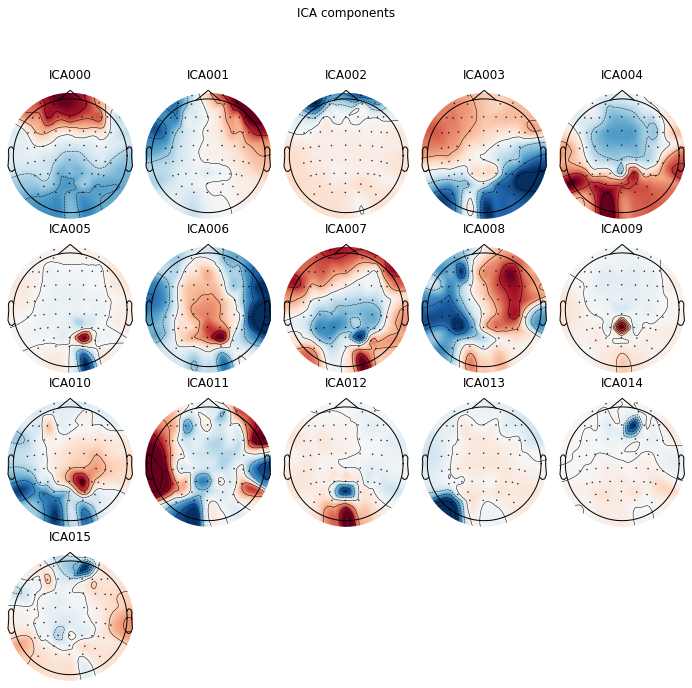

[<MNEFigure size 702x696.24 with 16 Axes>]

In [55]:
ica = mne.preprocessing.ICA(n_components=16, max_iter='auto', random_state=97)
ica.fit(epochs)
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1993 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
1993 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
1993 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
1993 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
1993 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
1993 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
1993 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
1993 matching e

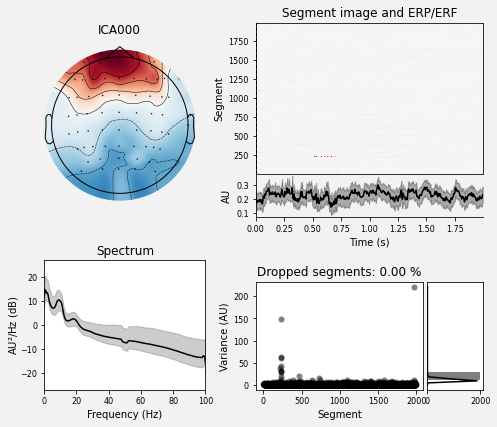

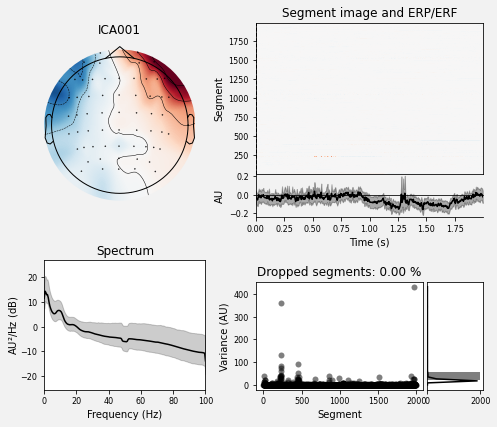

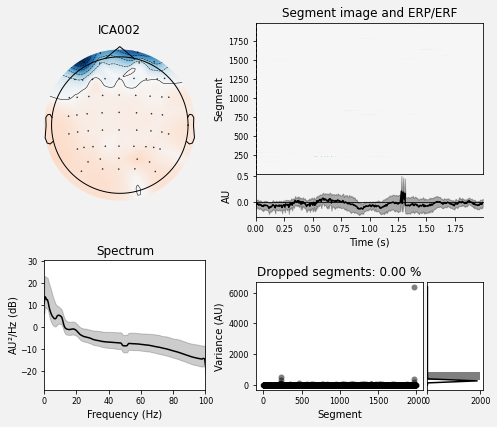

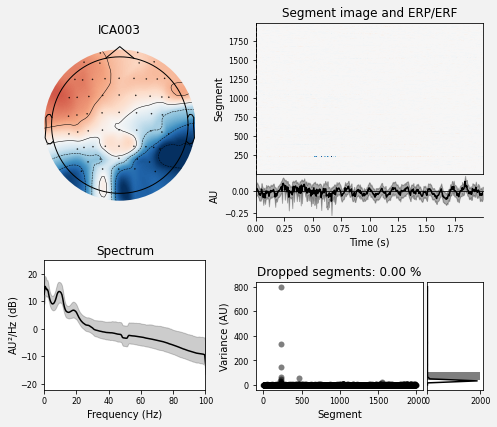

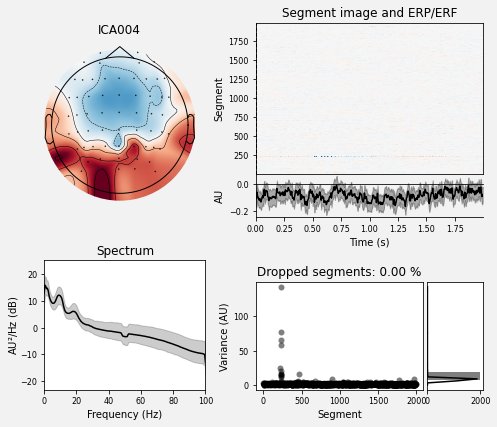

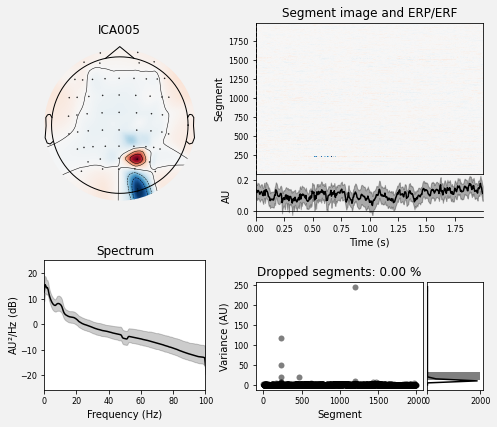

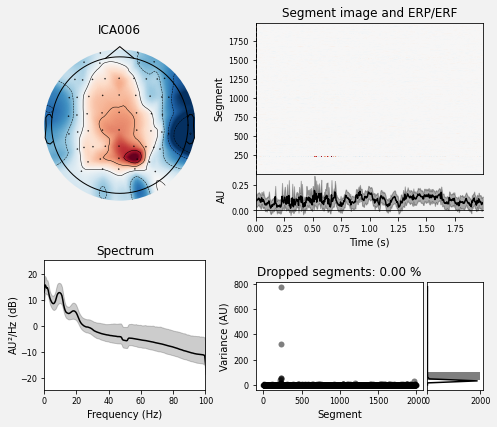

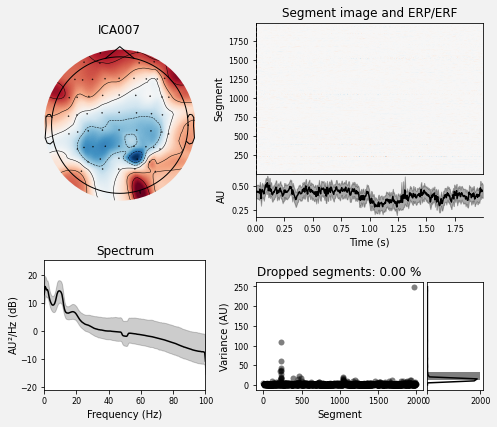

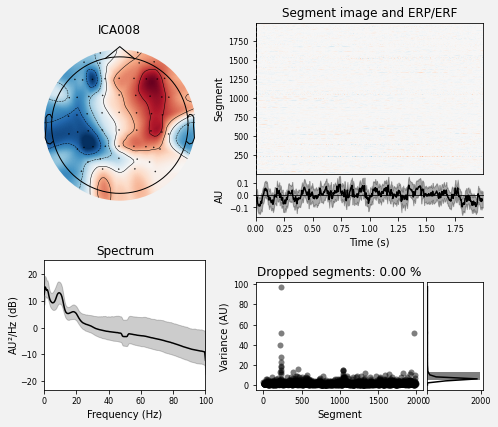

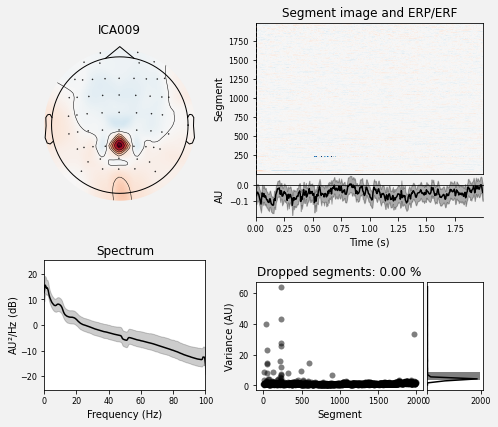

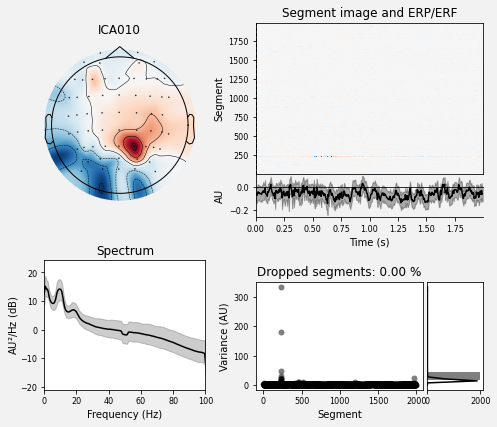

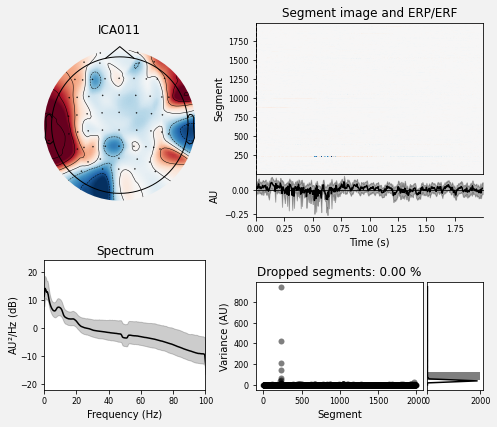

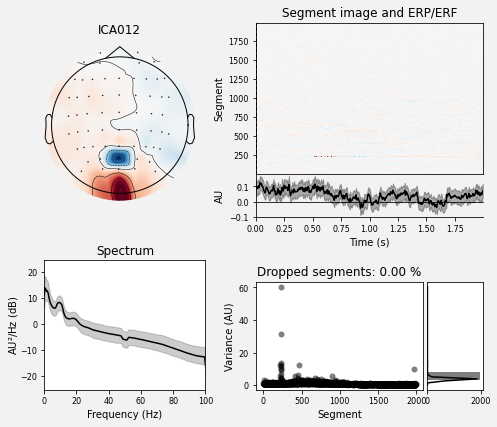

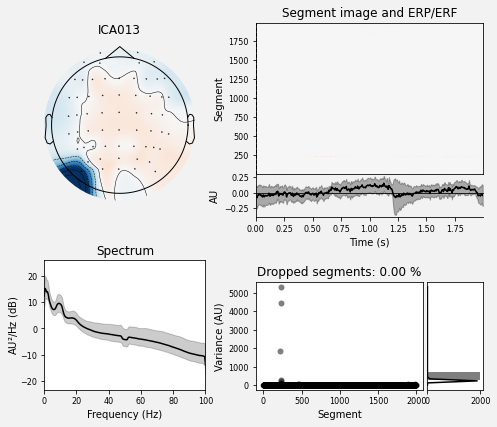

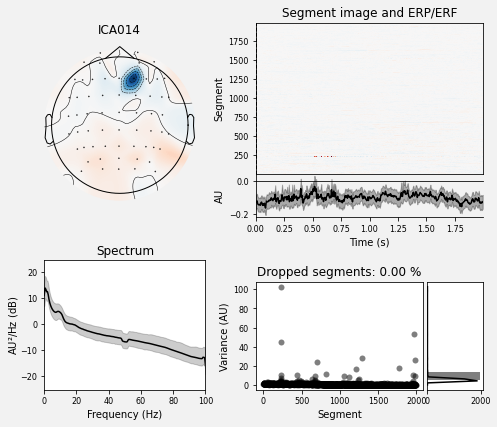

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [56]:
all_comps = [i for i in range(60)]
ica.plot_properties(raw_notch, picks=[0,1, 2, 3,4,5,6,7,8,9,10,11,12,13,14])

In [57]:
ica.exclude = [0, 1, 2, 3] #1, 2, 3, 4, 5, 6, 7, 8]

In [58]:
epochs_orig = epochs.copy()
ica.apply(epochs)
epochs.baseline = (1,2)

Applying ICA to Epochs instance


C:\Users\peter\AppData\Local\Temp\ipykernel_18356\2009219640.py:2: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (16 components)
    Zeroing out 4 ICA components
    Projecting back using 60 PCA components


In [133]:
epochs_resampled = epochs.resample(down=20, npad='auto')

TypeError: resample() got an unexpected keyword argument 'down'

### Create Grand Average of Epochs

Need more than one channel to make topography for eeg. Disabling interactivity.


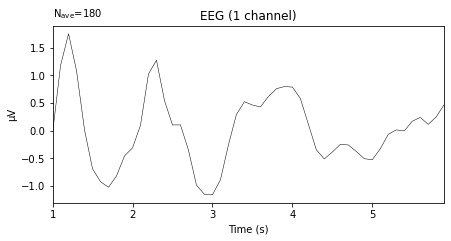

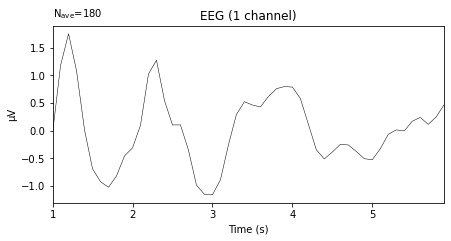

In [24]:
evoked = epochs['1'].average()

evoked.plot(picks='C1')



### Implementing cue-aligned (better according to Reinmar paper)

### Distance decoding:

2881 events found
Event IDs: [ 1  2 11 12 13 21 22 23 24 25 26 27 28 29 30]
Not setting metadata
360 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 360 events and 1201 original time points ...
0 bad epochs dropped
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


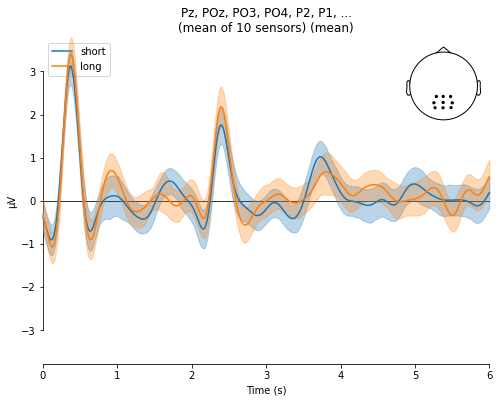

<Figure size 432x288 with 0 Axes>

In [25]:
events = mne.find_events(raw_lp, stim_channel='Markers')

event_dict = {'short': 1, 'long': 2, 'short': 1, 'long': 2, 'short':1, 'long':2, 'short':1, 'long':2}

epochs_long_short = mne.Epochs(raw_lp, events, event_id=event_dict, tmin=0, tmax=6, preload=True, baseline=(1,2)) #, baseline=(1,2))



short = epochs_long_short['short'].average()

long = epochs_long_short['long'].average()

#evokeds = dict(short=short, long=long)
#mne.viz.plot_compare_evokeds(evokeds, picks='POz')

evokeds2 = dict(short=list(epochs_long_short['short'].iter_evoked()),
               long=list(epochs_long_short['long'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds2, combine='mean', picks=['Pz', 'POz', 'PO3', 'PO4', 'P2', 'P1', 'P2', 'Oz', 'O1', 'O2'], show_sensors='upper right')
plt.savefig('distance_grand_averages.pdf')


epochs_long_short = epochs_long_short.copy().resample(10)

[2 2 1 2 1 2 2 1 2 1 1 1 2 1 1 2 2 1 2 2 2 1 2 1 2 1 1 1 2 1 1 2 2 1 1 2 1
 2 1 2 2 2 1 1 2 1 1 2 1 2 1 2 2 1 2 1 2 2 2 1 1 2 1 2 1 2 2 2 2 1 1 2 1 1
 2 1 1 2 1 1 2 1 1 2 2 2 2 2 2 1 1 1 1 2 1 2 1 1 2 2 2 1 1 1 2 2 1 2 2 1 1
 1 2 2 1 1 1 2 1 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 2 1 2 1 1 2 2 1 1 1 2 1 1 2
 2 2 2 2 1 2 2 1 2 1 1 1 2 2 2 2 1 2 2 2 1 1 1 2 2 1 2 1 1 2 2 1 1 1 1 1 2
 1 1 1 2 1 2 2 1 1 2 1 2 1 2 2 2 2 2 1 1 1 2 1 2 1 2 1 2 1 2 1 1 2 2 1 1 2
 2 1 2 1 1 1 1 2 2 2 1 2 1 2 2 1 1 2 1 1 2 2 2 1 2 1 2 2 1 1 1 2 1 2 2 1 2
 1 2 2 1 1 2 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 2 1 2 2 1 2 2 1 2 2 1 2 1 1 1 1
 1 1 2 1 2 2 2 1 1 2 1 1 2 2 1 2 1 1 2 1 2 1 2 2 1 1 1 2 1 2 2 1 2 1 2 2 2
 2 2 2 2 2 1 1 2 2 1 1 1 1 1 2 2 1 2 1 1 1 2 1 1 1 2 2]
[0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1
 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1
 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1
 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1

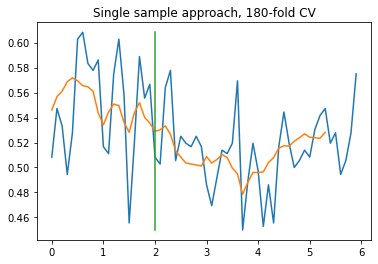

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = []
y = []
for i,epoch in enumerate(epochs_long_short):
    #print(epoch.shape)
    # Deleting EOG channels:
    epoch = np.delete(epoch, 40, 0)
    epoch = np.delete(epoch, 21, 0)
    epoch = np.delete(epoch, 16, 0)
    X.append(epoch[:61,:])
    y.append(list(epochs_long_short[i].event_id.values())[0])

X = np.array(X)
y = np.array(y)

print(y)

for i,label in enumerate(y):
    if label % 2 == 0:
        y[i] = 0
    else:
        y[i] = 1

print(y)


# Split training and test set:
from sklearn.model_selection import train_test_split, cross_val_score

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
acc = []
cv_scores = []
for idx in range(len(X[0,0])):
    x = X[:,:,idx]
    # Reshape X to 2d array:
    #nsamples, nx, ny = x.shape
    #x = x.reshape((nsamples,nx*ny))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(clf.score(X_test, y_test))
    
    scores = cross_val_score(clf, x, y, cv=180)
    cv_scores.append(scores.mean())
    
    if idx % 10 == 0:
        print(idx)

print('Done')

import matplotlib.pyplot as plt
t = np.arange(len(acc))
t = t/10
#plt.plot(t, acc)

plt.plot(t, cv_scores)

window = 7

ma = np.convolve(cv_scores, np.ones(window), 'valid') / window

plt.plot(t[:-window+1], ma)
plt.plot([2,2], [min(cv_scores), max(cv_scores)])
plt.title('Single sample approach, 180-fold CV')
plt.savefig('distance_acc_single.pdf')


0
(360, 61, 5)
10
(360, 61, 5)
20
(360, 61, 5)
30
(360, 61, 5)
40
(360, 61, 5)
50
(360, 61, 5)
Done


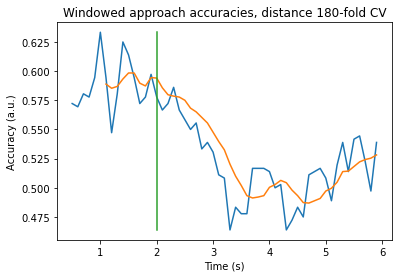

In [27]:
# 5 point LDA
X = []
y = []
for i,epoch in enumerate(epochs_long_short):
    #print(epoch.shape)
    # Deleting Marker channel:
    # Deleting EOG channels:
    epoch = np.delete(epoch, 40, 0)
    epoch = np.delete(epoch, 21, 0)
    epoch = np.delete(epoch, 16, 0)
    X.append(epoch[:61,:])
    y.append(list(epochs_long_short[i].event_id.values())[0])

for i,label in enumerate(y):
    if label % 2 == 0:
        y[i] = 0
    else:
        y[i] = 1

    
X = np.array(X)
y = np.array(y)


# Split training and test set:

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
acc = []
cv_scores = []
for idx in range(len(X[0,0])-5):
    x = X[:,:,idx:idx+5]
    if idx % 10 == 0:
        print(idx)
        print(x.shape)
    # Reshape X to 2d array:
    nsamples, nx, ny = x.shape
    x = x.reshape((nsamples,nx*ny))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(clf.score(X_test, y_test))
    
    scores = cross_val_score(clf, x, y, cv=180)
    cv_scores.append(scores.mean())
    
    

print('Done')
#print(acc)

import matplotlib.pyplot as plt
t = np.arange(len(acc))
t = t/10 + 5/10
#plt.plot(t, acc)

plt.plot(t, cv_scores)

window = 7

ma = np.convolve(cv_scores, np.ones(window), 'valid') / window

plt.plot(t[window-1:], ma)
plt.plot([2,2], [min(cv_scores), max(cv_scores)])
plt.xlabel('Time (s)')
plt.ylabel('Accuracy (a.u.)')
plt.title('Windowed approach accuracies, distance 180-fold CV')
plt.savefig('distance_acc_5point.pdf')

# Distinguish direction

2882 events found
Event IDs: [ 1  2 11 12 13 21 22 23 24 25 26 27 28 29 30]
Not setting metadata
360 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 360 events and 1201 original time points ...
0 bad epochs dropped
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


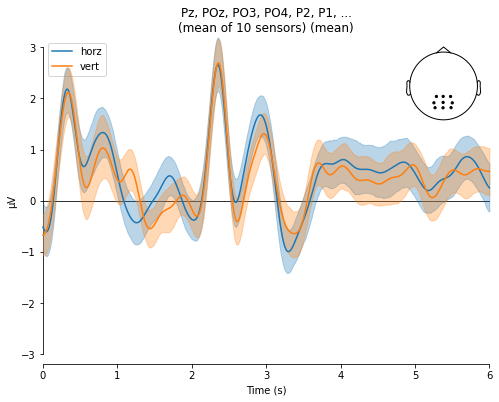

In [50]:
events = mne.find_events(raw_lp, stim_channel='Markers')

event_dict = {'horz': 1, 'vert':2}

epochs_direction = mne.Epochs(raw_lp, events, event_id=event_dict, tmin=0, tmax=6, preload=True, baseline=(1,2)) #, baseline=(1,2))



horz = epochs_direction['horz'].average()

vert = epochs_direction['vert'].average()

#evokeds = dict(short=short, long=long)
#mne.viz.plot_compare_evokeds(evokeds, picks='POz')

evokeds2 = dict(horz=list(epochs_direction['horz'].iter_evoked()),
               vert=list(epochs_direction['vert'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds2, combine='mean', picks=['Pz', 'POz', 'PO3', 'PO4', 'P2', 'P1', 'P2', 'Oz', 'O1', 'O2'], show_sensors='upper right')


epochs_direction = epochs_direction.copy().resample(10)

0
(360, 61, 5)
10
(360, 61, 5)
20
(360, 61, 5)
30
(360, 61, 5)
40
(360, 61, 5)
50
(360, 61, 5)
Done


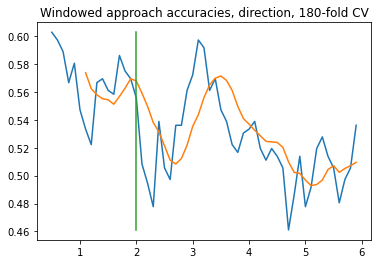

In [53]:
# 5 point LDA
X = []
y = []
for i,epoch in enumerate(epochs_direction):
    #print(epoch.shape)
    # Deleting Marker channel:
    # Deleting EOG channels:
    epoch = np.delete(epoch, 40, 0)
    epoch = np.delete(epoch, 21, 0)
    epoch = np.delete(epoch, 16, 0)
    X.append(epoch[:61,:])
    y.append(list(epochs_direction[i].event_id.values())[0])

for i,label in enumerate(y):
    if label % 2 == 0:
        y[i] = 0
    else:
        y[i] = 1

    
X = np.array(X)
y = np.array(y)


# Split training and test set:

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
acc = []
cv_scores = []
for idx in range(len(X[0,0])-5):
    x = X[:,:,idx:idx+5]
    if idx % 10 == 0:
        print(idx)
        print(x.shape)
    # Reshape X to 2d array:
    nsamples, nx, ny = x.shape
    x = x.reshape((nsamples,nx*ny))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(clf.score(X_test, y_test))
    
    scores = cross_val_score(clf, x, y, cv=180)
    cv_scores.append(scores.mean())
    
    

print('Done')
#print(acc)

import matplotlib.pyplot as plt
t = np.arange(len(acc))
t = t/10 + 5/10
#plt.plot(t, acc)

plt.plot(t, cv_scores)

window = 7

ma = np.convolve(cv_scores, np.ones(window), 'valid') / window

plt.plot(t[window-1:], ma)
plt.plot([2,2], [min(cv_scores), max(cv_scores)])
plt.xlabel('Time (s)')
plt.ylabel('Accuracy (a.u.)')
plt.title('Windowed approach accuracies, direction, 180-fold CV')
plt.savefig('direction_acc_5point.pdf')

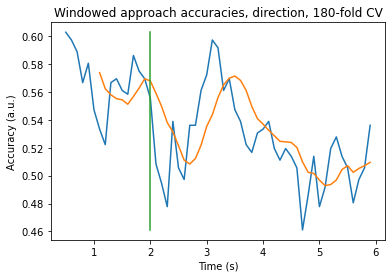

In [54]:
import matplotlib.pyplot as plt
t = np.arange(len(acc))
t = t/10 + 5/10
#plt.plot(t, acc)

plt.plot(t, cv_scores)

window = 7

ma = np.convolve(cv_scores, np.ones(window), 'valid') / window

plt.plot(t[window-1:], ma)
plt.plot([2,2], [min(cv_scores), max(cv_scores)])
plt.title('Windowed approach accuracies, direction, 180-fold CV')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy (a.u.)')
plt.savefig('direction_acc_5point.pdf')

In [ ]:
print(chn_names[40])
print(chn_names[21])
print(chn_names[16])

In [55]:
X = []
y = []
for i,epoch in enumerate(epochs):
    #print(epoch.shape)
    # Deleting EOG channels:
    epoch = np.delete(epoch, 40, 0)
    epoch = np.delete(epoch, 21, 0)
    epoch = np.delete(epoch, 16, 0)
    X.append(epoch[:61,:])
    y.append(list(epochs[i].event_id.values())[0])

X = np.array(X)
y = np.array(y)

Classify for length, therefore combine all even and all uneven class labels together.

In [56]:
for i,label in enumerate(y):
    if label % 2 == 0:
        y[i] = 0
    else:
        y[i] = 1

print(y)

[1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0
 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1
 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0
 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1
 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0
 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0
 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0
 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1
 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1]


In [57]:
print(len(X[0,0]))

60


0
10
20
30
40
Done
0
(90, 62, 5)
10
(90, 62, 5)
20
(90, 62, 5)
30
(90, 62, 5)
40
(90, 62, 5)
Done


Text(0.5, 1.0, 'Windowed approach accuracies, 44-fold CV')

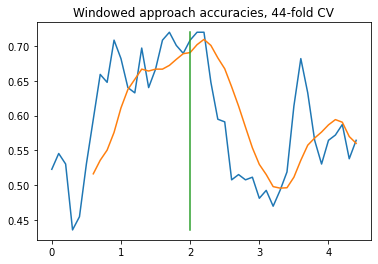

In [23]:
# Split training and test set:
from sklearn.model_selection import train_test_split, cross_val_score

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
acc = []
cv_scores = []
for idx in range(len(X[0,0])):
    x = X[:,:,idx]
    # Reshape X to 2d array:
    #nsamples, nx, ny = x.shape
    #x = x.reshape((nsamples,nx*ny))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(clf.score(X_test, y_test))
    
    scores = cross_val_score(clf, x, y, cv=44)
    cv_scores.append(scores.mean())
    
    if idx % 10 == 0:
        print(idx)

print('Done')
#print(acc)


In [134]:
# Reshape X to 2d array:
print(X.shape)
# Reshape X to 2d array:
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

print(X.shape)

(360, 62, 1201)
(360, 74462)


Text(0.5, 1.0, 'Single sample approach, 44-fold CV')

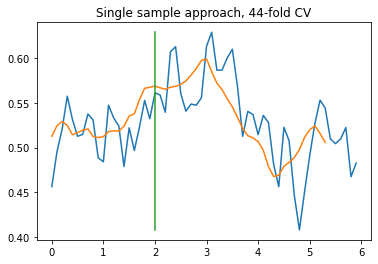

In [60]:
import matplotlib.pyplot as plt
t = np.arange(len(acc))
t = t/10
#plt.plot(t, acc)

plt.plot(t, cv_scores)

window = 7

ma = np.convolve(cv_scores, np.ones(window), 'valid') / window

plt.plot(t[:-window+1], ma)
plt.plot([2,2], [min(cv_scores), max(cv_scores)])
plt.title('Single sample approach, 44-fold CV')

In [61]:
# 5 point LDA
X = []
y = []
for i,epoch in enumerate(epochs):
    #print(epoch.shape)
    # Deleting Marker channel:
    # Deleting EOG channels:
    epoch = np.delete(epoch, 40, 0)
    epoch = np.delete(epoch, 21, 0)
    epoch = np.delete(epoch, 16, 0)
    X.append(epoch)
    y.append(list(epochs[i].event_id.values())[0])

for i,label in enumerate(y):
    if label % 2 == 0:
        y[i] = 0
    else:
        y[i] = 1

    
X = np.array(X)
y = np.array(y)


# Split training and test set:
from sklearn.model_selection import train_test_split, cross_val_score

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
acc = []
cv_scores = []
for idx in range(len(X[0,0])-5):
    x = X[:,:,idx:idx+5]
    if idx % 10 == 0:
        print(idx)
        print(x.shape)
    # Reshape X to 2d array:
    nsamples, nx, ny = x.shape
    x = x.reshape((nsamples,nx*ny))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(clf.score(X_test, y_test))
    
    scores = cross_val_score(clf, x, y, cv=44)
    cv_scores.append(scores.mean())
    
    

print('Done')
#print(acc)

0
(360, 62, 5)
10
(360, 62, 5)
20
(360, 62, 5)
30
(360, 62, 5)
40
(360, 62, 5)
50
(360, 62, 5)
Done


Text(0.5, 1.0, 'Windowed approach accuracies, 44-fold CV')

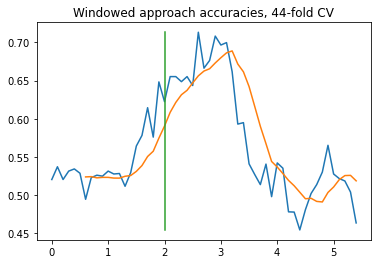

In [62]:
import matplotlib.pyplot as plt
t = np.arange(len(acc))
t = t/10
#plt.plot(t, acc)

plt.plot(t, cv_scores)

window = 7

ma = np.convolve(cv_scores, np.ones(window), 'valid') / window

plt.plot(t[window-1:], ma)
plt.plot([2,2], [min(cv_scores), max(cv_scores)])
plt.title('Windowed approach accuracies, 44-fold CV')

In [63]:
print(epochs.ch_names)

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'EOGC', 'CP5', 'CP1', 'CP2', 'CP6', 'EOGR', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'EOGL', 'FT7', 'FC3', 'FC4', 'FT8', 'FCz', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Markers']


In [17]:
# Split training and test set:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print(len(X_train[0]))

76864


In [ ]:
clf = LinearDiscriminantAnalysis()
for idx in len(X_train[0]):
    x_train = X_train[:,idx]
    x_test = X_test[:,idx]
    clf.fit(x_train, y_train)

In [85]:
y_pred = clf.predict(X_test)

In [87]:
print(y_pred)
print(y_test)

[1 1 0 1 0 1 1 1]
[0 0 0 1 0 0 0 1]


### Implementing movement-onset aligned

In [ ]:
print(len(epoch))

62


# Extract markers for touch/release, with corresponding timestamps

#### First, we store the markers and the timestamps into new variables

In [5]:
markers_copy = raw.get_data()[64,:]
time_stamps = raw.times

### Next, we extract only non-zero markers with corresponding timestamps

In [6]:
nonzero_markers = markers_copy[markers_copy!=0]
nonzero_ts = time_stamps[markers_copy!=0]

#### Now we will check how many markers are left

In [7]:
print(f'Before cleaning the shape of the markers was {markers_copy.shape}'
      f'\nand now it is {nonzero_markers.shape}\n')
print(f'Before cleaning the shape of the timestamps was {time_stamps.shape}'
      f'\nand now it is {nonzero_ts.shape}')

Before cleaning the shape of the markers was (787344,)
and now it is (2882,)

Before cleaning the shape of the timestamps was (787344,)
and now it is (2882,)


#### Next, we want to see, how much the touches/releases were deleayed after the start of a run.

#### A run starts with a start cue which has the label 11, and a touch has an uneven number between 21 and 29, and a release has an even number between 22 and 30

In [8]:
num_start_cues = len(nonzero_markers[nonzero_markers==11])
print(num_start_cues)
num_cue_cues = len(nonzero_markers[nonzero_markers==12])
print(num_cue_cues)
num_touch_release = len(nonzero_markers[(nonzero_markers>20)])
print(num_touch_release)

# Find incorrect runs, a correct run is started by 11 and follwed
# by 8 non-eleven markers until the next 11 arrives, therefore
# we measure the number of elements between two elevens:

start_idcs = np.where(nonzero_markers==11)[0]
markers_per_run = np.diff(start_idcs)
invalid_runs = np.where(markers_per_run!=8)[0]
print(invalid_runs)
print(f'Found {len(invalid_runs)} invalid runs.')

# runs = []
# for i, mark in enumerate(nonzero_markers):
#     if mark == 11.:
#         runs.append(nonzero_markers[i:i+8])

# print(runs)




360
360
1442
[36]
Found 1 invalid runs.


### Align correct runs

In [9]:
valid_nonzero_markers = []
valid_nonzero_ts = []
valid_rel_ts = []
for i,idx in enumerate(start_idcs):
    if i in invalid_runs:
        pass
    else:
        valid_nonzero_markers.append(nonzero_markers[idx:idx+8])
        valid_nonzero_ts.append(nonzero_ts[idx:idx+8])

        # Re-referenced valid timestamps to beginning of epoch:
        valid_rel_ts.append(valid_nonzero_ts[-1][:] - valid_nonzero_ts[-1][0])


### Calculate average second touch:

In [11]:
first_touch = []
first_release = []
second_touch = []
second_release = []
for i in range(len(valid_rel_ts)):
    first_touch.append(valid_rel_ts[i][1])
    first_release.append(valid_rel_ts[i][3])
    second_touch.append(valid_rel_ts[i][4])
    second_release.append(valid_rel_ts[i][6])

print(f'First touch: {round(np.mean(first_touch), 2)} +/- {round(np.std(first_touch), 2)}')
print(f'First release: {round(np.mean(first_release), 2)} +/- {round(np.std(first_release), 2)}')
print(f'Second touch: {round(np.mean(second_touch), 2)} +/- {round(np.std(second_touch), 2)}')
print(f'Second release: {round(np.mean(second_release), 2)} +/- {round(np.std(second_release), 2)}')

First touch: 1.12 +/- 0.13
First release: 3.12 +/- 0.3
Second touch: 3.96 +/- 0.35
Second release: 7.87 +/- 0.1
